In [127]:
import torch 
import torchvision
# models from torchvision allows to use pre-trained from pytorch library
from torchvision import datasets, transforms, models # standard pkg that has datasets and transforms
import numpy as np
import matplotlib.pyplot as plt
#from sklearn import datasets
"""
Import functional modules and neural networl impl from Pytorch
"""
from torch import nn
import torch.nn.functional as F

In [128]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [129]:
!git clone https://github.com/jaddoescad/ants_and_bees.git

fatal: destination path 'ants_and_bees' already exists and is not an empty directory.


In [130]:
ls ants_and_bees/train/ants

Parameter format not correct - "rain".


In [131]:
# Include data augmentation for training network to learn data variations (transform_images)
# Only training dataset is augmented
transform_train = transforms.Compose([transforms.Resize((224,224)), # resize for validation
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)), # shear = angle change, scale= using tuple to scale down img size
                                transforms.ColorJitter(brightness=1, contrast=0.2, saturation=0.2), # color alteration of images      
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

transform = transforms.Compose([transforms.Resize((224,224)), # resize for validation
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# training_dataset     
training_dataset = datasets.ImageFolder(root='ants_and_bees/train', transform=transform_train)
# validation dataset
# mainly for testing purposes
validation_dataset = datasets.ImageFolder(root='ants_and_bees/val', transform=transform)

In [132]:
print(len(training_dataset)) # print no. of images (training)
print(len(validation_dataset)) # print no. of images (validation)

244
153


In [133]:
# Reduce the batch size from 100 to 20 due to training using a pre-trained network, and the dataset size is relatively small (10172020)
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=20, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=20, shuffle=False)

In [134]:
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy() # convert data into numpy array
    image = image.transpose(1, 2, 0)
#    print(image.shape)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

In [135]:
#classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
classes = ('ant', 'bee')

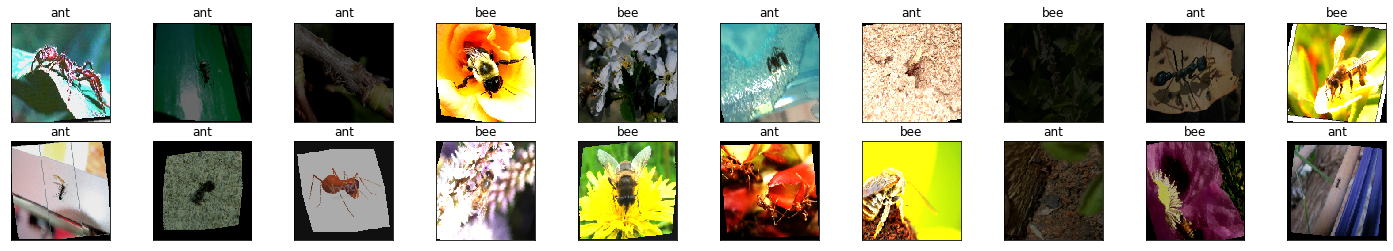

In [136]:
# Create object that allows iterable to run
dataiter = iter(training_loader)
images, labels = dataiter.next()
#images = images.to(device)
#labels = labels.to(device)
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[]) # plot 2 rows, 10 col per row, creating index per row
    plt.imshow(im_convert(images[idx]))
#    ax.set_title([labels[idx].item()])
    ax.set_title(classes[labels[idx].item()])

In [137]:
# Using AlexNet for transfer learning using pre-trained network - 10182020
#model = models.alexnet(pretrained=True).to(device)
#model = models.alexnet(pretrained=True)
model = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\user/.cache\torch\hub\checkpoints\vgg16-397923af.pth


In [107]:
# Continue 10/07/2020 (evening)
print(model)# 28 px * 28 px = 784 pixels for MNIST(784 nodes necesary)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [138]:
for param in model.features.parameters():
    param.requires_grad = False

In [139]:
n_inputs = model.classifier[6].in_features # Call the 6th input of the classifier -> refer to model
last_layer = nn.Linear(n_inputs, len(classes)) # create a new output layer to corresponds to no. of classes we have
model.classifier[6] = last_layer

print(model.classifier[6].out_features)
#model.to(device)

2


In [140]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) # tips, start with a high learning rate then adjust based on results whether loss fluctuates or not (skewness)

In [ ]:
epochs = 10
running_loss_history = []
running_corrects_history = []
# validation running history
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
            
    running_loss = 0.0
    running_corrects = 0.0     
    val_running_loss = 0.0
    val_running_corrects = 0.0
    
    for inputs, labels in training_loader:
#        inputs = inputs.to(device)
#        labels = labels.to(device)
        # remove flattening as we're inputting full dimensional layer of image
#        inputs = inputs.view(inputs.shape[0], -1)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
        _, preds = torch.max(outputs, 1)

        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        
    else:
        # save memory
        with torch.no_grad():
            for val_inputs, val_labels in validation_loader:
                # remove flattening as we're inputting full dimensional layer of image                
#                val_inputs = val_inputs.view(val_inputs.shape[0], -1)
#                val_inputs = val_inputs.to(device)
#                val_labels = val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
            
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)
        
        epoch_loss = running_loss / len(training_loader.dataset)
        epoch_acc = running_corrects.float() / len(training_loader.dataset) #gives probability from value 0 to 1
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)
        
        val_epoch_loss = val_running_loss / len(validation_loader.dataset)
        val_epoch_acc = val_running_corrects.float() / len(validation_loader.dataset)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)
        
        print("epoch: ", e+1)
    
        if(e == 14):
            print("Finished!")

        print("training loss: {:.4f}, training correct: {:.4f}".format(epoch_loss, epoch_acc.item()))
        print("validation loss: {:.4f}, validation correct: {:.4f}".format(val_epoch_loss, val_epoch_acc.item()))        

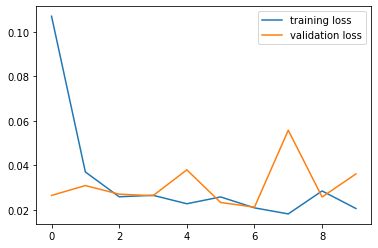

In [112]:
plt.plot(running_loss_history, label="training loss")
plt.plot(val_running_loss_history, label="validation loss")
plt.legend()
#plt.plot(running_corrects_history, label="training accuracy")

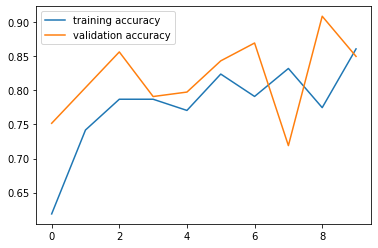

In [113]:
plt.plot(running_corrects_history, label="training accuracy")
plt.plot(val_running_corrects_history, label="validation accuracy")
plt.legend()

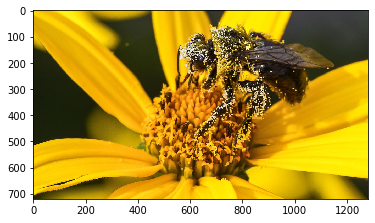

In [123]:
# Final tests (10152020)
import requests
import PIL.ImageOps
from PIL import Image
#url = 'https://i.guim.co.uk/img/media/9988a21ff2c14703e6be54cf00b584b86764d672/945_1419_3421_2052/master/3421.jpg?width=1200&height=900&quality=85&auto=format&fit=crop&s=94a14e3ec4dcb5495693791e6df4a265'
#url = 'https://images.newscientist.com/wp-content/uploads/2019/10/16151942/cataglyphisbombycinasoldier1uniulmdouzfotohwolf.jpg'
url = 'https://www.sciencemag.org/sites/default/files/styles/article_main_large/public/images/cc_bees_16x9.jpg?itok=MCrBaUfm'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)
#print(response)

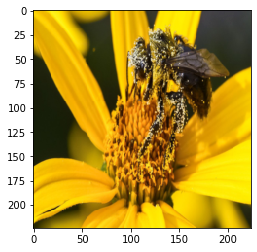

In [124]:
#img = PIL.ImageOps.invert(img)
#img = img.convert('1')
img = transform(img)
plt.imshow(im_convert(img))

In [125]:
# remove flattening
#img = img.view(img.shape[0], -1)
#image = img.to(device).unsqueeze(0)
image = img.unsqueeze(0)
#image = img.to(device)
# remove unsqueezing of image
#image = images[0].unsqueeze(0).unsqueeze(0)

output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

bee


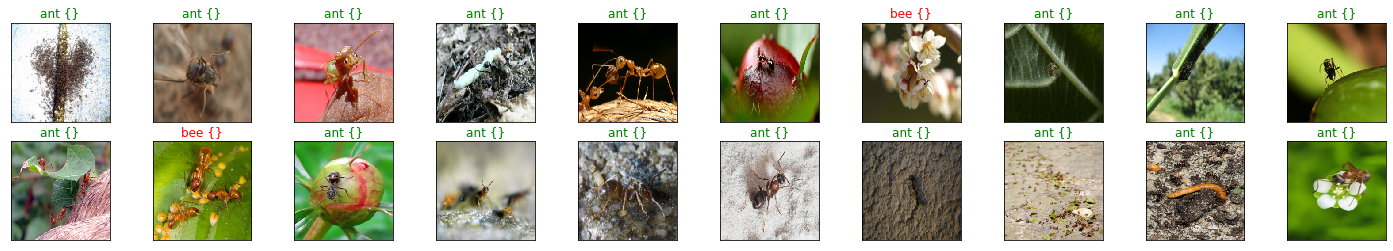

In [126]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
#images = images.to(device)
#labels = labels.to(device)
#images_ = images.view(images.shape[0], -1)
output = model(images)

_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[]) # plot 2 rows, 10 col per row, creating index per row
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} {{}}".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))